In [51]:
import json
import pandas as pd
import hvplot.pandas
import holoviews as hv

from prophet import Prophet
from alpaca_trade_api.rest import REST, TimeFrame

In [71]:
# Read the secret data from env file
with open("env", "r") as f:
  secret = json.loads(f.read())

# Get data from Alpaca API with 1 hour interval between 2018-01-01 and 2022-10-19
with REST(key_id=secret['ALPACA_API_KEY'], secret_key=secret['ALPACA_SECRET_KEY']) as api:
    data = api.get_crypto_bars("BTCUSD", TimeFrame.Hour, "2018-01-01", "2022-10-19").df

# Chose only FTXU data
ftx_data = data[data.exchange == 'FTXU']

# Prepare dataset for Prophet model
prophet_data = ftx_data.reset_index()
prophet_data = prophet_data[['timestamp','close']]
prophet_data.columns = ['ds','y']
prophet_data['ds'] = prophet_data['ds'].apply(lambda x: x.replace(tzinfo=None)) # remove timezone from timestamp

In [72]:
# Holoviews extension to render hvPlot plots in Colab
hv.extension('bokeh')

# Plot predictions for our forecast period
prophet_data[['ds', 'y']].hvplot()

Output hidden; open in https://colab.research.google.com to view.

In [73]:
model = Prophet() # Create model object
model.fit(prophet_data) # fit model 

DEBUG:cmdstanpy:input tempfile: /tmp/tmpdabktad8/lkmcubla.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdabktad8/pu2qex6p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93279', 'data', 'file=/tmp/tmpdabktad8/lkmcubla.json', 'init=/tmp/tmpdabktad8/pu2qex6p.json', 'output', 'file=/tmp/tmpdabktad8/prophet_model5ntkksn3/prophet_model-20221023175103.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:51:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:51:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [75]:
# Create a future DataFrame to hold predictions
# Make the prediction go out as far as 1000 hours 
future = model.make_future_dataframe(periods=1000, freq='H')

# Review the first and last 10 rows of the DataFrame
display(future.head(10))
display(future.tail(10))

,ds
0,2020-04-08 08:00:00
1,2020-04-14 06:00:00
2,2020-04-14 07:00:00
3,2020-04-22 23:00:00
4,2020-04-28 12:00:00
5,2020-04-29 03:00:00
6,2020-04-30 12:00:00
7,2020-05-01 00:00:00
8,2020-05-01 05:00:00
9,2020-05-01 16:00:00


,ds
20082,2022-11-30 11:00:00
20083,2022-11-30 12:00:00
20084,2022-11-30 13:00:00
20085,2022-11-30 14:00:00
20086,2022-11-30 15:00:00
20087,2022-11-30 16:00:00
20088,2022-11-30 17:00:00
20089,2022-11-30 18:00:00
20090,2022-11-30 19:00:00
20091,2022-11-30 20:00:00


In [76]:
# Make a forecast based on the future DataFrame
forecast = model.predict(future)

# Review the first five rows of the forecast DataFrame
display(forecast.head())
display(forecast.tail())

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-04-08 08:00:00,-16024.514928,-1924.065927,3860.733788,-16024.514928,-16024.514928,17026.299617,17026.299617,17026.299617,6.810097,...,58.525219,58.525219,58.525219,16960.964301,16960.964301,16960.964301,0.0,0.0,0.0,1001.784689
1,2020-04-14 06:00:00,-14605.137106,88.671948,5509.750842,-14605.137106,-14605.137106,17425.224929,17425.224929,17425.224929,-3.176195,...,-16.320994,-16.320994,-16.320994,17444.722118,17444.722118,17444.722118,0.0,0.0,0.0,2820.087823
2,2020-04-14 07:00:00,-14595.141488,52.032632,5820.450322,-14595.141488,-14595.141488,17435.804158,17435.804158,17435.804158,5.498668,...,-19.588912,-19.588912,-19.588912,17449.894402,17449.894402,17449.894402,0.0,0.0,0.0,2840.662670
3,2020-04-22 23:00:00,-12516.052848,4224.311061,9758.642315,-12516.052848,-12516.052848,19371.672023,19371.672023,19371.672023,17.190834,...,131.563240,131.563240,131.563240,19222.917948,19222.917948,19222.917948,0.0,0.0,0.0,6855.619175
4,2020-04-28 12:00:00,-11186.635592,6587.310701,12043.510056,-11186.635592,-11186.635592,20488.396853,20488.396853,20488.396853,8.076654,...,-31.212149,-31.212149,-31.212149,20511.532347,20511.532347,20511.532347,0.0,0.0,0.0,9301.761260


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
20087,2022-11-30 16:00:00,28888.155874,6935.160551,21834.751799,21008.714181,35506.557566,-14365.949219,-14365.949219,-14365.949219,-6.630970,...,115.261464,115.261464,115.261464,-14474.579714,-14474.579714,-14474.579714,0.0,0.0,0.0,14522.206655
20088,2022-11-30 17:00:00,28891.450496,6401.216471,21801.870369,20999.935783,35523.435759,-14382.920136,-14382.920136,-14382.920136,-13.081869,...,120.039984,120.039984,120.039984,-14489.878251,-14489.878251,-14489.878251,0.0,0.0,0.0,14508.530360
20089,2022-11-30 18:00:00,28894.745117,6766.928970,21400.473810,20992.244191,35534.433213,-14393.716455,-14393.716455,-14393.716455,-12.596376,...,124.075283,124.075283,124.075283,-14505.195362,-14505.195362,-14505.195362,0.0,0.0,0.0,14501.028662
20090,2022-11-30 19:00:00,28898.039738,6209.290790,21583.994851,20984.508440,35545.430666,-14399.423336,-14399.423336,-14399.423336,-6.207770,...,127.315242,127.315242,127.315242,-14520.530808,-14520.530808,-14520.530808,0.0,0.0,0.0,14498.616402
20091,2022-11-30 20:00:00,28901.334360,6283.409578,21230.822188,20976.549965,35556.428120,-14403.470701,-14403.470701,-14403.470701,2.698109,...,129.715535,129.715535,129.715535,-14535.884345,-14535.884345,-14535.884345,0.0,0.0,0.0,14497.863659


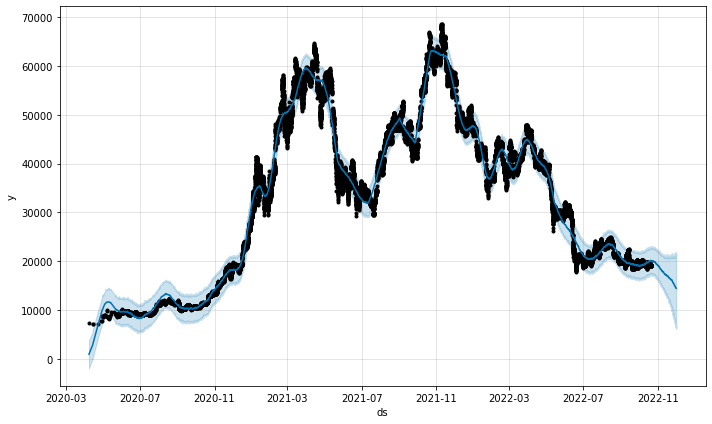

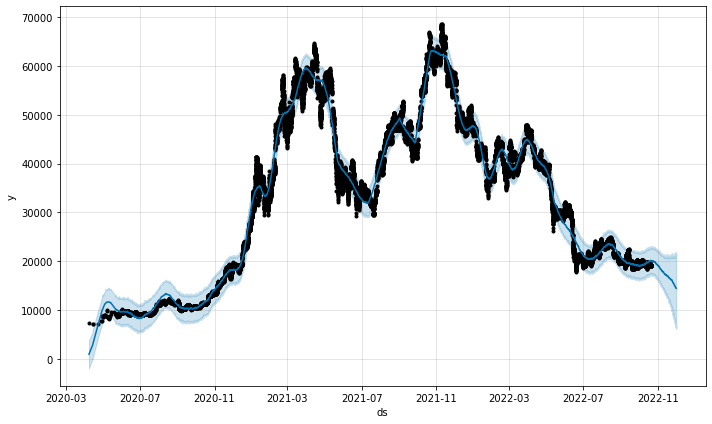

In [77]:
# Plot the forecast using the model’s plot function
model.plot(forecast)

In [78]:
  # Display the underlying forecast dataframe (tail)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
20087,2022-11-30 16:00:00,14522.206655,6935.160551,21834.751799
20088,2022-11-30 17:00:00,14508.530360,6401.216471,21801.870369
20089,2022-11-30 18:00:00,14501.028662,6766.928970,21400.473810
20090,2022-11-30 19:00:00,14498.616402,6209.290790,21583.994851
20091,2022-11-30 20:00:00,14497.863659,6283.409578,21230.822188


In [79]:
# Reset the index to this datetime column so that our plot looks nice
forecast = forecast.set_index('ds')

# Display the DataFrame
forecast.head()

,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
ds,,,,,,,,,,,,,,,,,,,,,
2020-04-08 08:00:00,-16024.514928,-1924.065927,3860.733788,-16024.514928,-16024.514928,17026.299617,17026.299617,17026.299617,6.810097,6.810097,...,58.525219,58.525219,58.525219,16960.964301,16960.964301,16960.964301,0.0,0.0,0.0,1001.784689
2020-04-14 06:00:00,-14605.137106,88.671948,5509.750842,-14605.137106,-14605.137106,17425.224929,17425.224929,17425.224929,-3.176195,-3.176195,...,-16.320994,-16.320994,-16.320994,17444.722118,17444.722118,17444.722118,0.0,0.0,0.0,2820.087823
2020-04-14 07:00:00,-14595.141488,52.032632,5820.450322,-14595.141488,-14595.141488,17435.804158,17435.804158,17435.804158,5.498668,5.498668,...,-19.588912,-19.588912,-19.588912,17449.894402,17449.894402,17449.894402,0.0,0.0,0.0,2840.662670
2020-04-22 23:00:00,-12516.052848,4224.311061,9758.642315,-12516.052848,-12516.052848,19371.672023,19371.672023,19371.672023,17.190834,17.190834,...,131.563240,131.563240,131.563240,19222.917948,19222.917948,19222.917948,0.0,0.0,0.0,6855.619175
2020-04-28 12:00:00,-11186.635592,6587.310701,12043.510056,-11186.635592,-11186.635592,20488.396853,20488.396853,20488.396853,8.076654,8.076654,...,-31.212149,-31.212149,-31.212149,20511.532347,20511.532347,20511.532347,0.0,0.0,0.0,9301.761260


In [80]:
# Holoviews extension to render hvPlot plots in Colab
hv.extension('bokeh')

# Plot predictions for our forecast period
forecast[['yhat', 'yhat_lower', 'yhat_upper']].iloc[-720:,:].hvplot()

Output hidden; open in https://colab.research.google.com to view.

In [81]:
# Reset "ds" from the datetime index back to a column
forecast = forecast.reset_index()
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-04-08 08:00:00,-16024.514928,-1924.065927,3860.733788,-16024.514928,-16024.514928,17026.299617,17026.299617,17026.299617,6.810097,...,58.525219,58.525219,58.525219,16960.964301,16960.964301,16960.964301,0.0,0.0,0.0,1001.784689
1,2020-04-14 06:00:00,-14605.137106,88.671948,5509.750842,-14605.137106,-14605.137106,17425.224929,17425.224929,17425.224929,-3.176195,...,-16.320994,-16.320994,-16.320994,17444.722118,17444.722118,17444.722118,0.0,0.0,0.0,2820.087823
2,2020-04-14 07:00:00,-14595.141488,52.032632,5820.450322,-14595.141488,-14595.141488,17435.804158,17435.804158,17435.804158,5.498668,...,-19.588912,-19.588912,-19.588912,17449.894402,17449.894402,17449.894402,0.0,0.0,0.0,2840.662670
3,2020-04-22 23:00:00,-12516.052848,4224.311061,9758.642315,-12516.052848,-12516.052848,19371.672023,19371.672023,19371.672023,17.190834,...,131.563240,131.563240,131.563240,19222.917948,19222.917948,19222.917948,0.0,0.0,0.0,6855.619175
4,2020-04-28 12:00:00,-11186.635592,6587.310701,12043.510056,-11186.635592,-11186.635592,20488.396853,20488.396853,20488.396853,8.076654,...,-31.212149,-31.212149,-31.212149,20511.532347,20511.532347,20511.532347,0.0,0.0,0.0,9301.761260


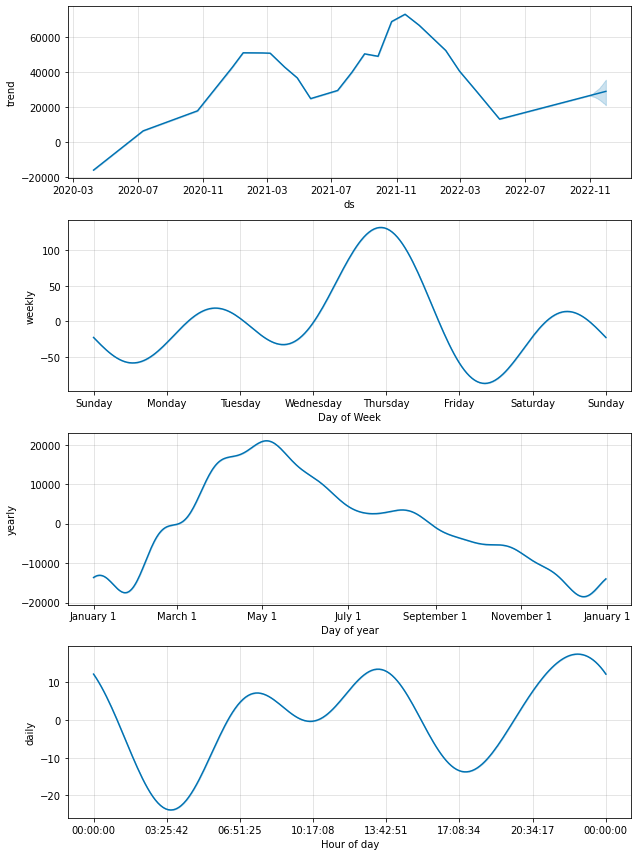

In [82]:
# Plot the individual time series components of the model
fig2 = model.plot_components(forecast)

## Result
#### Based on a prediction we can say that the BitCoin price will be decreasing next 1000 hours.
#### It is gonna reach as low as 16 000 USD by 21-11-2022.
#### So my recomendation is to sell BitCoin now